# Calculating downside risk measures

In [1]:
# Import libraries 
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# Load the data
hfi_data = pd.read_csv('../input/python/edhec-hedgefundindices.csv',
                           header=0, index_col=0, parse_dates=True)
hfi_data.shape

(263, 13)

In [3]:
hfi_data.head()

,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
1997-01-31,1.19,3.93,1.78,7.91,1.89,2.13,1.91,5.73,2.81,1.50,1.80,-1.66,3.17
1997-02-28,1.23,2.98,1.22,5.25,1.01,0.84,1.22,1.75,-0.06,0.34,1.18,4.26,1.06
1997-03-31,0.78,-0.21,-0.12,-1.20,0.16,-0.23,1.09,-1.19,-0.84,0.60,0.10,7.78,-0.77
1997-04-30,0.86,-1.70,0.30,1.19,1.19,-0.05,1.30,1.72,0.84,-0.01,1.22,-1.29,0.09
1997-05-31,1.56,-0.15,2.33,3.15,1.89,3.46,1.18,1.08,3.94,1.97,1.73,-7.37,2.75


## Preprocessing

In [4]:
# Convert to percentages 
hfi_data = hfi_data/100
hfi_data.index = hfi_data.index.to_period('M')
hfi_data.head()

,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
1997-01,0.0119,0.0393,0.0178,0.0791,0.0189,0.0213,0.0191,0.0573,0.0281,0.0150,0.0180,-0.0166,0.0317
1997-02,0.0123,0.0298,0.0122,0.0525,0.0101,0.0084,0.0122,0.0175,-0.0006,0.0034,0.0118,0.0426,0.0106
1997-03,0.0078,-0.0021,-0.0012,-0.0120,0.0016,-0.0023,0.0109,-0.0119,-0.0084,0.0060,0.0010,0.0778,-0.0077
1997-04,0.0086,-0.0170,0.0030,0.0119,0.0119,-0.0005,0.0130,0.0172,0.0084,-0.0001,0.0122,-0.0129,0.0009
1997-05,0.0156,-0.0015,0.0233,0.0315,0.0189,0.0346,0.0118,0.0108,0.0394,0.0197,0.0173,-0.0737,0.0275


## Semideviation

Formula 

$$\sigma_{semi} = \sqrt{\frac{1}{N}\sum_{x_{t} \leq \bar{x}} (x_{t} - \bar{x})^{2}}$$ 

<p style="text-align:center;"> N = number of entries which fall below the mean.</p> 

In [5]:
# Calculate the standard deviation 
std = hfi_data.std(ddof=0)
std.sort_values(ascending=False)

Short Selling             0.047655
Emerging Markets          0.032476
CTA Global                0.023290
Long/Short Equity         0.019897
Distressed Securities     0.017009
Event Driven              0.016712
Convertible Arbitrage     0.016536
Funds Of Funds            0.015536
Global Macro              0.014694
Fixed Income Arbitrage    0.011517
Relative Value            0.011462
Merger Arbitrage          0.009600
Equity Market Neutral     0.008115
dtype: float64

In [6]:
# Calculate the standard deviation for returns which have negative values 
semi_std = hfi_data[hfi_data<0].std(ddof=0)
semi_std.sort_values(ascending=False)

Emerging Markets          0.028039
Short Selling             0.027283
Convertible Arbitrage     0.019540
Fixed Income Arbitrage    0.017763
Event Driven              0.015429
Distressed Securities     0.015185
Long/Short Equity         0.014051
CTA Global                0.012443
Relative Value            0.012244
Funds Of Funds            0.012122
Equity Market Neutral     0.009566
Merger Arbitrage          0.008875
Global Macro              0.006579
dtype: float64

#### Comparison

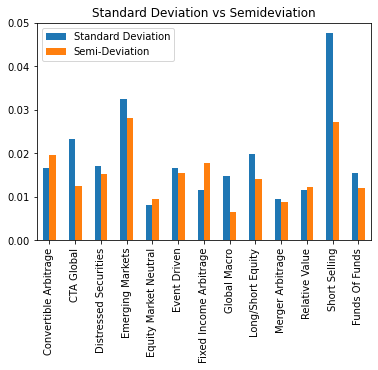

In [7]:
comparison = pd.concat([std, semi_std], axis=1)
comparison.columns = ["Standard Deviation", "Semi-Deviation"]
comparison.plot.bar(title="Standard Deviation vs Semideviation")

## Value at Risk (VaR) and Conditional VaR 

We will try three different methods to calculate the VaR

* Historical VaR
* Parametric VaR - Gaussian 
* Modified Cornish-Fisher VaR

### Historic VaR

In [8]:
np.percentile(hfi_data, 5, axis=0)

array([-0.01576, -0.03169, -0.01966, -0.04247, -0.00814, -0.02535,
       -0.00787, -0.01499, -0.02598, -0.01047, -0.01174, -0.06783,
       -0.02047])

In [9]:
def var_historic(r, level=5):
    '''
    ARG
        r: Dataframe with the returns
        level: percentile level
    Returns 
        percentile for each column
    '''
    # Check the type of data
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else: 
        raise TypeError("Expected r to be a series or dataframe")

In [10]:
var_historic(hfi_data, level=5) 

Convertible Arbitrage     0.01576
CTA Global                0.03169
Distressed Securities     0.01966
Emerging Markets          0.04247
Equity Market Neutral     0.00814
Event Driven              0.02535
Fixed Income Arbitrage    0.00787
Global Macro              0.01499
Long/Short Equity         0.02598
Merger Arbitrage          0.01047
Relative Value            0.01174
Short Selling             0.06783
Funds Of Funds            0.02047
dtype: float64

#### Parametric VaR - Gaussian 

z-score = $ \frac{x - \mu}{\sigma} $

In [11]:
from scipy.stats import norm

In [12]:
# Compute the z score assuming the data is gaussian 
# Percent point function
z = norm.ppf(0.05)
z

-1.6448536269514729

In [13]:
# Compute the gaussian VaR
var_gauss = -(hfi_data.mean() + z*hfi_data.std(ddof=0))
var_gauss

Convertible Arbitrage     0.021691
CTA Global                0.034235
Distressed Securities     0.021032
Emerging Markets          0.047164
Equity Market Neutral     0.008850
Event Driven              0.021144
Fixed Income Arbitrage    0.014579
Global Macro              0.018766
Long/Short Equity         0.026397
Merger Arbitrage          0.010435
Relative Value            0.013061
Short Selling             0.080086
Funds Of Funds            0.021292
dtype: float64

#### Cornish Fisher VaR (Non Gaussian)
Adjustments made for Skewness and Kurtosis

In [14]:
# Make a skewness function 
def skewness(r):
    '''
        ARGS:
            Series or Dataframe
        
        RETURNS: 
            Float or a series data with the calculated skewness
    '''
    
    # Calculate the demeaned returns 
    demeaned_r = r - r.mean()
    
    # Use the population standard deviation, ddof=0
    sigma_r = r.std(ddof=0)
    
    # Calculate the expectation of the demeaned returns raised to the third power
    exp = (demeaned_r**3).mean()
    
    # Calcualte the skew
    skew = exp/sigma_r**3
    return skew

In [15]:
# Make a kurtosis function 
def kurtosis(r):
    '''
        ARGS:
            Series or Dataframe
        
        RETURNS: 
            Float or a series data with the calculated kurtosis
    '''
    
    # Calculate the demeaned returns 
    demeaned_r = r - r.mean()
    
    # Use the population standard deviation, ddof=0
    sigma_r = r.std(ddof=0)
    
    # Calculate the expectation of the demeaned returns raised to the fourth power
    exp = (demeaned_r**4).mean()
    
    # Calcualte the skew
    kurt = exp/sigma_r**4
    return kurt

In [16]:
# Update z 
k = kurtosis(hfi_data)
s = skewness(hfi_data)
z = norm.ppf(0.05)
z = (z + (z**2 - 1)*s/6 + (z**3 - 3*z)*(k-3)/24 - (2 * z**3 - 5*z)*(s**2)/36)

In [17]:
mcf_var = -(hfi_data.mean() + z*hfi_data.std(ddof=0))
mcf_var

Convertible Arbitrage     0.025166
CTA Global                0.033094
Distressed Securities     0.025102
Emerging Markets          0.053011
Equity Market Neutral     0.010734
Event Driven              0.025516
Fixed Income Arbitrage    0.017881
Global Macro              0.013581
Long/Short Equity         0.027935
Merger Arbitrage          0.012612
Relative Value            0.016157
Short Selling             0.066157
Funds Of Funds            0.021576
dtype: float64

In [18]:
# Calculate the skewness and kurtosis 
stats = pd.concat([s, k], axis=1)
stats.columns = ["Skewness", "Kurtosis"]
stats

,Skewness,Kurtosis
Convertible Arbitrage,-2.639592,23.280834
CTA Global,0.173699,2.952960
Distressed Securities,-1.300842,7.889983
Emerging Markets,-1.167067,9.250788
Equity Market Neutral,-2.124435,17.218555
Event Driven,-1.409154,8.035828
Fixed Income Arbitrage,-3.940320,29.842199
Global Macro,0.982922,5.741679
Long/Short Equity,-0.390227,4.523893
Merger Arbitrage,-1.320083,8.738950


In [19]:
# Compare all three by plotting 
results = [var_gauss, mcf_var, var_historic(hfi_data, level=5)]
comparison=pd.concat(results, axis=1)
comparison.columns = ["Gaussian", "Cornish-Fisher", "Historic"]
comparison

,Gaussian,Cornish-Fisher,Historic
Convertible Arbitrage,0.021691,0.025166,0.01576
CTA Global,0.034235,0.033094,0.03169
Distressed Securities,0.021032,0.025102,0.01966
Emerging Markets,0.047164,0.053011,0.04247
Equity Market Neutral,0.008850,0.010734,0.00814
Event Driven,0.021144,0.025516,0.02535
Fixed Income Arbitrage,0.014579,0.017881,0.00787
Global Macro,0.018766,0.013581,0.01499
Long/Short Equity,0.026397,0.027935,0.02598
Merger Arbitrage,0.010435,0.012612,0.01047


Text(0, 0.5, 'Value at Risk')

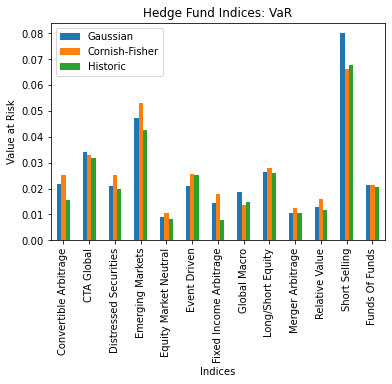

In [20]:

# Plot the comparison DataFrame
ax = comparison.plot.bar(title="Hedge Fund Indices: VaR")
ax.set_xlabel("Indices")
ax.set_ylabel("Value at Risk")

### Conditional VaR or Beyond VaR

$$ CVaR = -E(R| R \leq VaR) $$

In [21]:
# Create a cvar function 
def cvar_historic(r, level=5):
    """
        Computes the conditional VaR of Series or DataFrame
    """
    
    if isinstance(r, pd.Series): 
        is_beyond = r <= -var_historic(r, level=5) 
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else: 
        raise TypeError("Expected a dataframe or series")

In [22]:
cvar_historic(hfi_data, level=5)

Convertible Arbitrage     0.036550
CTA Global                0.041264
Distressed Securities     0.036429
Emerging Markets          0.072364
Equity Market Neutral     0.016879
Event Driven              0.038336
Fixed Income Arbitrage    0.028257
Global Macro              0.020629
Long/Short Equity         0.041943
Merger Arbitrage          0.019143
Relative Value            0.024650
Short Selling             0.096821
Funds Of Funds            0.033207
dtype: float64